In [2]:
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiLineString
from shapely.ops import substring, nearest_points
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False
# 加载矢量数据
river_gdf = gpd.read_file('../data/最新赣江河流.shp')
# 打印矢量数据的坐标系
print("河流坐标系 CRS:", river_gdf.crs)


河流坐标系 CRS: EPSG:4326


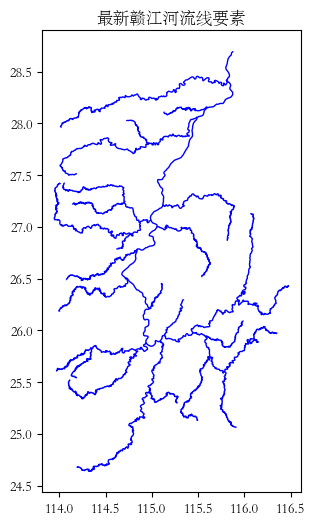

In [3]:
# 可视化河流数据
fig, ax = plt.subplots(figsize=(10, 6))
river_gdf.plot(ax=ax, color='blue', linewidth=1)
ax.set_title("最新赣江河流线要素")
plt.show()


In [4]:
import geopandas as gpd
from shapely.geometry import Point
from collections import defaultdict
import pandas as pd

# 定义一个函数来查找河流的起点和交汇点
def find_start_and_intersections(rivers):
    intersection_points = {}
    river_dict = defaultdict(set)

    # 提取每条河流的起点
    start_points = {}
    for idx, river in rivers.iterrows():
        start_point = Point(river.geometry.coords[0])
        start_points[start_point.wkt] = start_point

    # 计算交汇点
    for idx1, river1 in rivers.iterrows():
        for idx2, river2 in rivers.iterrows():
            if idx1 >= idx2:
                continue
            intersection = river1.geometry.intersection(river2.geometry)
            if not intersection.is_empty:
                if intersection.geom_type == 'Point':
                    if intersection.wkt not in intersection_points:
                        intersection_points[intersection.wkt] = intersection
                    river_dict[intersection.wkt].update([river1['编码'], river2['编码']])
                elif intersection.geom_type == 'MultiPoint':
                    for point in intersection.geoms:
                        if point.wkt not in intersection_points:
                            intersection_points[point.wkt] = point
                        river_dict[point.wkt].update([river1['编码'], river2['编码']])
                elif intersection.geom_type in ['LineString', 'MultiLineString']:
                    for coord in intersection.coords:
                        point = Point(coord)
                        if point.wkt not in intersection_points:
                            intersection_points[point.wkt] = point
                        river_dict[point.wkt].update([river1['编码'], river2['编码']])

    return list(start_points.values()), list(intersection_points.values()), river_dict

# 使用示例
# river_gdf = gpd.read_file('your_river_data.shp')  # 加载河流数据
start_points, intersection_points, river_mapping = find_start_and_intersections(river_gdf)

# 创建 DataFrame 存储起点和交汇点
all_points = start_points + intersection_points
point_ids = list(range(52, 52 + len(all_points)))  # 从 52 开始生成 point_id

# 创建 DataFrame
points_df = pd.DataFrame({
    'point_id': point_ids,
    'geometry': all_points
})

# 创建 GeoDataFrame
points_gdf = gpd.GeoDataFrame(points_df, geometry='geometry', crs=river_gdf.crs)

# 保存起点和交汇点到同一个文件
points_gdf.to_file('../data/起点和交汇点.shp')

print("起点和交汇点已保存为 '起点和交汇点.shp'")


起点和交汇点已保存为 '起点和交汇点.shp'


In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj

def generate_candidate_points(rivers, start_id, distance_interval=10000):  # distance_interval in meters
    candidate_points = []
    point_ids = []

    # 定义投影转换
    project_to_utm = pyproj.Transformer.from_crs(rivers.crs, "EPSG:32650", always_xy=True).transform
    project_to_geo = pyproj.Transformer.from_crs("EPSG:32650", rivers.crs, always_xy=True).transform

    # 遍历每条河流
    for idx, river in rivers.iterrows():
        river_line = river.geometry
        
        # 将河流线转换为 UTM 坐标系
        river_line_utm = transform(project_to_utm, river_line)
        
        # 计算河流的总长度
        total_length = river_line_utm.length
        
        # 从起点开始生成候选点
        distance = 0
        while distance <= total_length:
            # 计算候选点的位置
            point_utm = river_line_utm.interpolate(distance)
            candidate_points.append(transform(project_to_geo, point_utm))  # 转换回原坐标系
            
            # 添加对应的 point_id
            point_ids.append(start_id)
            start_id += 1
            
            distance += distance_interval

    return candidate_points, point_ids

# 从上一个单元格生成的起点和交汇点的点 ID 开始
last_point_id = 52 + len(points_gdf)  # 根据之前生成的点数计算起始 point_id
candidate_points, point_ids = generate_candidate_points(river_gdf, last_point_id)

# 创建 DataFrame 存储候选点
candidate_points_gdf = gpd.GeoDataFrame(geometry=candidate_points, crs=river_gdf.crs)

# 添加 point_id
candidate_points_gdf['point_id'] = point_ids

# 保存候选点到文件
candidate_points_gdf.to_file('../data/潜在候选点.shp')

print("候选点已保存为 '潜在候选点.shp'")


候选点已保存为 '候选点.shp'


In [8]:
# 将候选点的 CRS 转换为与起点和交汇点相同的 CRS（假设为 UTM）
candidate_points_gdf = candidate_points_gdf.to_crs(points_gdf.crs)

# 合并起点、交汇点和潜在候选点
total_candidate_points = gpd.GeoDataFrame(pd.concat([points_gdf, candidate_points_gdf], ignore_index=True), crs=points_gdf.crs)

# 将合并后的候选点转换为 EPSG:4326
total_candidate_points = total_candidate_points.to_crs("EPSG:4326")

# 保存合并后的候选点到文件
total_candidate_points.to_file('../data/总候选点.shp')

print("总候选点已保存为 '总候选点.shp'，坐标系为 EPSG:4326")


总候选点已保存为 '总候选点.shp'，坐标系为 EPSG:4326


In [11]:
# 读取保留的赣江断面数据
sections_gdf = gpd.read_file('../data/保留的赣江断面.shp')

# 合并候选点和断面数据
combined_gdf = gpd.GeoDataFrame(pd.concat([total_candidate_points, sections_gdf], ignore_index=True), crs=total_candidate_points.crs)

# 保存合并后的结果
combined_gdf.to_file('../data/含有保留点的总候选点.shp', encoding='utf-8')

print("合并后的候选点和断面已保存为 '合并后的候选点和断面.shp'")


合并后的候选点和断面已保存为 '合并后的候选点和断面.shp'


In [12]:
# 读取保留的赣江断面数据
sections_gdf = gpd.read_file('../data/赣江流域断面点.shp')

# 合并候选点和断面数据
combined_gdf = gpd.GeoDataFrame(pd.concat([total_candidate_points, sections_gdf], ignore_index=True), crs=total_candidate_points.crs)

# 保存合并后的结果
combined_gdf.to_file('../data/含有全部已有监测点的总候选点.shp', encoding='utf-8')

print("合并后的候选点和断面已保存为 '合并后的候选点和断面.shp'")


合并后的候选点和断面已保存为 '合并后的候选点和断面.shp'
